In [1]:
"""
심화 학습: 가우스 혼합 모델, gaussian mixture model

k-평균 모델의 비확률적 성질과 순집의 소속을 할당하는데 군집 중심으로부터의 거리를 사용하는 것은
수많은 실제 상황에서 성능을 떨어뜨리는 원인
가우스 혼합 모델 => k-평균의 개념을 확장한 것
"""
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, seaborn as sns; sns.set()

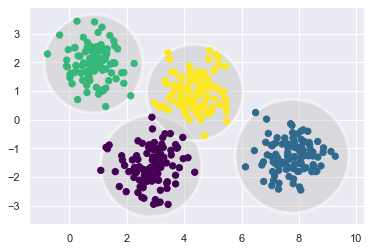

In [2]:
# GMM 등장 배경: k-평균의 약점
# k-평균 모델 시각화
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)

X = X[:, ::-1] # swap columns (x coord. <=> y coord.)

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # 입력 데이터 플로팅
    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    
    # k-평균 모델 표시
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc="#CCCCCC", lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

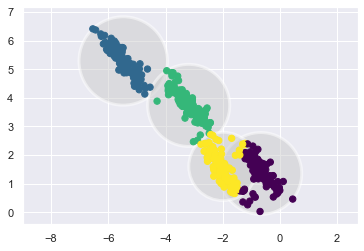

In [3]:
# k-평균에서 이 군집 모델이 원향이어야 한다는 점
# 똑같은 데이터를 가져다가 변환하면 군집할당이 뒤죽박죽
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

# 변환된 군집이 원형이 아님 => 원형 균집이 제대로 적합되지 않는다

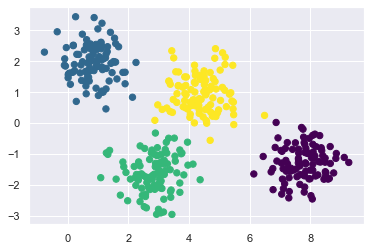

In [4]:
# E-M 단계 일반화하기: 가우스 혼합 모델
# 다차원 가우스 확률 분포의 혼잡률
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis");

In [5]:
# GMM이 내부적으로 확률 모델을 포함하고 있기에 확률적으로 군집을 할당하는 것도 가능
# predict_proba 메서드 => 특정 군집에 속한 모든 점들의 확률을 측정한 크기가 [n_samples, n_features]인 행렬 반환
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


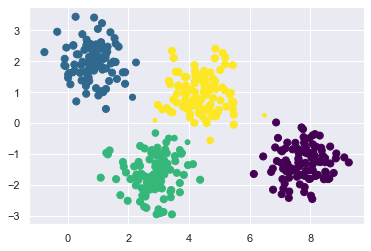

In [6]:
# 불확실성을 예를 들어 각 점의 크기를 그 예측의 확실성에 비례하게 만들어서 표현
size = 50 * probs.max(1) ** 2 # 제곱으로 차이를 강조
plt.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap="viridis");

# 경계에 근접한 점들은 확률이 작음으로 점 크기가 작다

In [7]:
"""
가우스 혼합 모델은 k-평균과 매우 비슷하다
기댓값 - 최대화 방식

1. 위치와 모양을 예측한다
2. 수렴될 때까지 다음 단계를 반복한다
    E-단계: 각 점에 대해 각 군집의 일원일 가능성을 인코딩한 가중치를 구한다
    M-단계: 모든 데이터 점을 기반으로 가중치를 사용해 각 군집의 위치, 정규화, 모양을 업데이트한다
"""

# gmm 결과를 기반으로 한 타원형을 그려서 GMM 군집의 위치와 모양을 시각화할 함수 생성
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """주어진 위치와 공분산으로 타원 그리기"""
    ax = ax or plt.gca()
    # 공분산을 주측으로 전환
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # 타원 그리기
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
    
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis("equal")
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

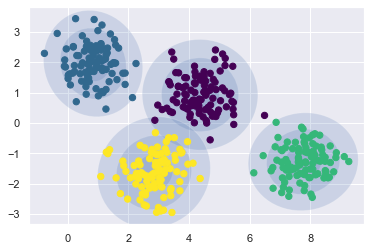

In [8]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

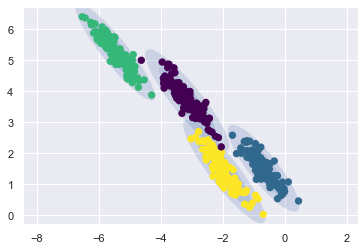

In [9]:
# 펼쳐진 모양의 데이터세트를 적합
gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
plot_gmm(gmm, X_stretched)

In [10]:
# covariance_type = ["diag", "spherical, "full", ...]

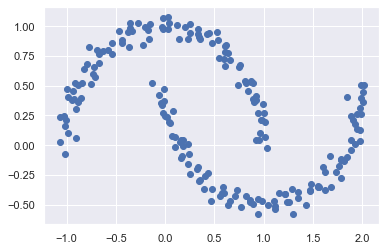

In [11]:
# 밀도 추정에 GMM 사용하기
# GMM은 근본적으로는 밀도 추정 알고리즘, GMM을 적합한 결과는 기술적으로 데이터의 분포를 나타내는 생성 확률 모델
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

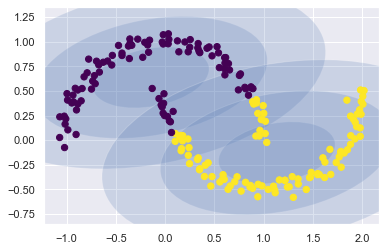

In [12]:
# 2-성분 GMM 군집화 모델 => 쓸모 없는 결과
gmm2 = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
plot_gmm(gmm2, Xmoon)

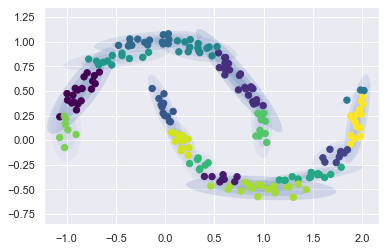

In [13]:
# 더 많은 성분을 사용하고 군집 레이블을 무시
gmm16 = GaussianMixture(n_components=16, covariance_type="full", random_state=0)
plot_gmm(gmm16, Xmoon)

# 16개의 가우스 혼합은 분리된 데이터 군집 발견이 아니라 입력 데이터의 전반적은 분포를 모델링하는데 이용

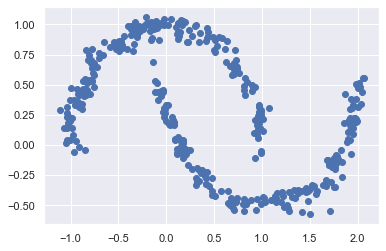

In [14]:
# 원본 데이터에 적합시킨 16-성분 GMM으로부터 얻어낸 400개의 새로운 데이터
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

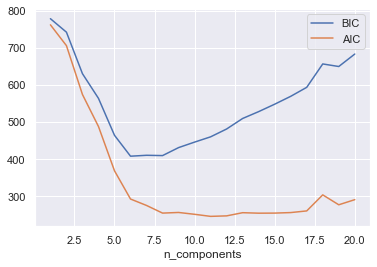

In [15]:
# 얼마나 많은 성분을 사용할 것인가?
# AIC, Akaike information criterion / BIC, baysian information criterion
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type="full", random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label="BIC")
plt.plot(n_components, [m.aic(Xmoon) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components");

In [16]:
# 예제: 새로운 데이터를 생성하는 GMM
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

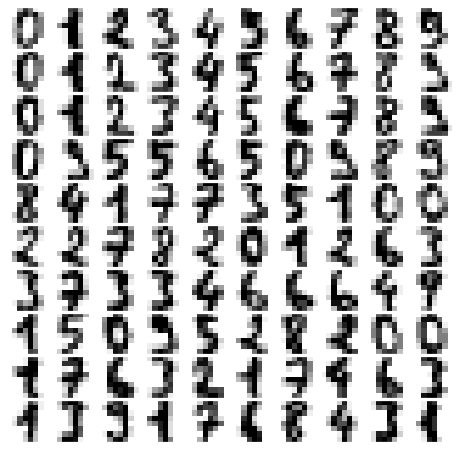

In [17]:
# 처음 100개의 데이터만 플로팅
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[],yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap="binary")
        im.set_clim(0, 16)

plot_digits(digits.data)

In [18]:
# GMM은 고차원 공간(64)에서 수렴이 어려울 수 있으므로
# 간단한 PCA를 사용하고 사영된 데이터에서 분산의 99%를 보존
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

# 정보 유실은 거의 없이 차원은 1/3 수준으로 축소된 41차원의 데이터

(1797, 41)

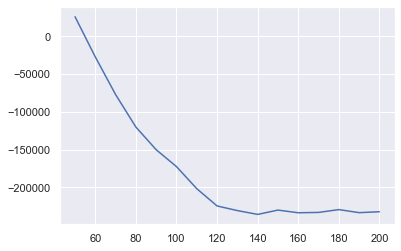

In [19]:
# PCA로 사영된 데이터를 가지고 AIC를 사용해 예제에 쓸 GMM 성분 개수 의 기준을 구해 보자
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type="full", random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics); # 약 110개의 성분이 AIC를 최소화

In [20]:
# 110개의 성분으로 GMM 모델 생성 후 수렴하는지 확인
gmm = GaussianMixture(110, covariance_type="full", random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [21]:
# 생성 모델로 GMM을 사용해 41차원의 사영된 공간에서 100개의 새로운 점의 표본
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

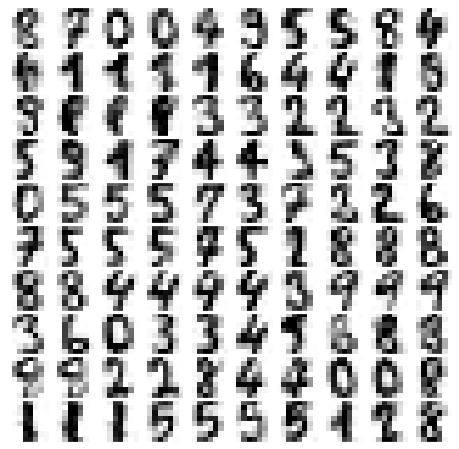

In [22]:
# 새로운 숫자를 구성하기 위해 PCA 객체의 가역 변환
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)